# Images Chest X-Ray Classification

*dataset: chest x-ray*

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

## Library

In [31]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

from train import train_model

exist_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [2]:
print(exist_gpu)

False


## Dataset

In [3]:

TRN_DIR = "data/train"
VAL_DIR = 'data/val'
TST_DIR = 'data/test'

sz = 224
batch_size = 4

### For fun
 <hr style="height:2px;border-width:0;color:gray;background-color:gray"> 

In [4]:
os.listdir(TRN_DIR)

['NORMAL', 'PNEUMONIA']

In [5]:
trn_fnames = glob.glob(f'{TRN_DIR}/*/*.jpeg')
trn_fnames

['data/train\\NORMAL\\NORMAL2-IM-1379-0001.jpeg',
 'data/train\\NORMAL\\NORMAL2-IM-1385-0001.jpeg',
 'data/train\\NORMAL\\NORMAL2-IM-1396-0001.jpeg',
 'data/train\\NORMAL\\NORMAL2-IM-1400-0001.jpeg',
 'data/train\\NORMAL\\NORMAL2-IM-1401-0001.jpeg',
 'data/train\\NORMAL\\NORMAL2-IM-1406-0001.jpeg',
 'data/train\\NORMAL\\NORMAL2-IM-1412-0001.jpeg',
 'data/train\\NORMAL\\NORMAL2-IM-1419-0001.jpeg',
 'data/train\\NORMAL\\NORMAL2-IM-1422-0001.jpeg',
 'data/train\\NORMAL\\NORMAL2-IM-1423-0001.jpeg',
 'data/train\\PNEUMONIA\\person1935_bacteria_4847.jpeg',
 'data/train\\PNEUMONIA\\person1935_bacteria_4848.jpeg',
 'data/train\\PNEUMONIA\\person1935_bacteria_4849.jpeg',
 'data/train\\PNEUMONIA\\person1935_bacteria_4850.jpeg',
 'data/train\\PNEUMONIA\\person1936_bacteria_4852.jpeg',
 'data/train\\PNEUMONIA\\person1937_bacteria_4853.jpeg',
 'data/train\\PNEUMONIA\\person1938_bacteria_4854.jpeg',
 'data/train\\PNEUMONIA\\person1940_bacteria_4859.jpeg',
 'data/train\\PNEUMONIA\\person1940_bacteria

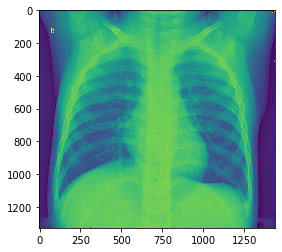

In [6]:
img = plt.imread(trn_fnames[0])
plt.imshow(img);

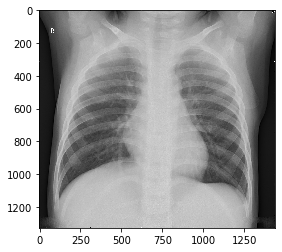

In [7]:
plt.imshow(img, cmap='gray');

 <hr style="height:2px;border-width:0;color:gray;background-color:gray"> 

In [8]:
mytfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
train_ds = datasets.ImageFolder(TRN_DIR, transform=mytfms)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor. thanks Naser Razavi
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)

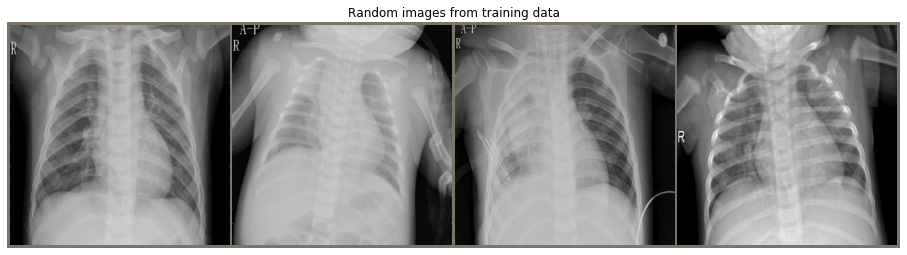

In [13]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

In [14]:
targets

tensor([1, 1, 1, 0])

## Local Model

In [15]:
class chestCNN(nn.Module):
    
    def __init__(self):
        super(chestCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=2),
            nn.ReLU()
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
        )
        
        self.fc = nn.Linear(28 * 28 * 64, 2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)   
        out = self.conv3(out)         
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [16]:
model = chestCNN()

# transfer model to GPU
if exist_gpu:
    model = model.cuda()

In [17]:
model

chestCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (fc): Linear(in_features=50176, out_features=2, bias=True)
)

In [18]:
outputs = model(inputs)
print(outputs)

tensor([[-0.0544,  0.0134],
        [-0.0614, -0.0275],
        [-0.0292,  0.0041],
        [-0.0570,  0.0031]], grad_fn=<AddmmBackward>)


## Loss Function

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

## Train

In [20]:
def to_var(x, volatile=False):
    if exist_gpu:
        x = x.cuda()
    return Variable(x, volatile=volatile)

In [ ]:
num_epochs = 5
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = to_var(inputs)
        targets = to_var(targets)
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses.append(loss)
        # backward pass
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss))

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');

## Exprimental

In [21]:
test_ds = datasets.ImageFolder(TST_DIR, transform=mytfms)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)

In [22]:
def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [ ]:
evaluate_model(model, train_dl)

In [ ]:
evaluate_model(model, test_dl)

## Data Agumentation

In [27]:
trn_tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [28]:
train_ds = datasets.ImageFolder(TRN_DIR, transform=trn_tfms)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)

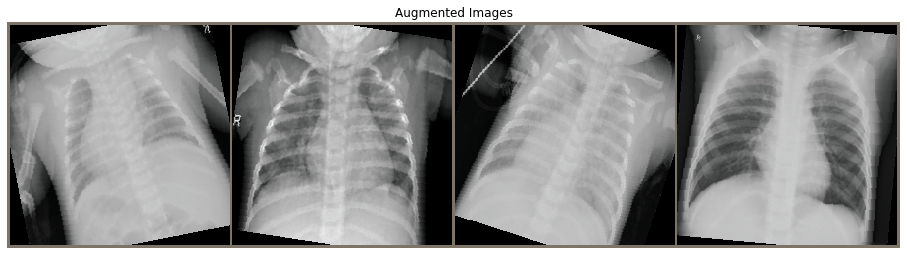

In [29]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Augmented Images')

In [30]:
targets

tensor([1, 0, 1, 0])

In [32]:
valid_ds = datasets.ImageFolder(VAL_DIR, transform=mytfms)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)

In [36]:
# train
model = train_model(model, train_dl, valid_dl, criterion, optimizer, num_epochs=5)

Epoch 1/5
----------
  train Loss: 0.68430 Acc: 0.00000


C:\Users\RayanPshitaz\Project\Week01\train.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


  valid Loss: 0.74083 Acc: 0.00000

Epoch 2/5
----------
  train Loss: 0.73305 Acc: 0.00000
  valid Loss: 0.68424 Acc: 0.00000

Epoch 3/5
----------
  train Loss: 0.69815 Acc: 0.00000
  valid Loss: 0.67907 Acc: 0.00000

Epoch 4/5
----------
  train Loss: 0.69424 Acc: 0.00000
  valid Loss: 0.68434 Acc: 0.00000

Epoch 5/5
----------
  train Loss: 0.67051 Acc: 0.00000
  valid Loss: 0.68274 Acc: 0.00000

Training complete in 2m 6s
Best val Acc: 0.0000


In [37]:
evaluate_model(model, train_dl)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


accuracy: 64.00


In [38]:
evaluate_model(model, test_dl)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


accuracy: 50.00


## Transfer Learning

In [47]:
def get_model(model_name, pretrained=False):
    return models.__dict__[model_name](pretrained)

In [48]:
class my_per_Network(nn.Module):
    
    def __init__(self, cnn, embed_size=10):
        super(my_per_Network, self).__init__()
        
        num_features = cnn.fc.in_features
        cnn.fc = nn.Linear(num_features, embed_size) 
        self.cnn = cnn

    def forward(self, x):
        f = self.cnn(x)
        return f

In [51]:
pre_modelName = "resnet18"
model = get_model(pre_modelName, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\RayanPshitaz/.cache\torch\checkpoints\resnet18-5c106cde.pth


In [52]:
def get_resnet18(model_path=None, num_classes=10):
    if model_path is None:
        model = models.resnet18(pretrained=True)
        for param in model.parameters():
            param.require_grad = False
            
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    else:
        model = models.resnet18(pretrained=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        model.load_state_dict(torch.load(model_path))
    
    if exist_gpu:
        model = model.cuda()
        
    return model

In [53]:
# load pre-trained ResNet18
model = get_resnet18(model_path=None, num_classes=2)


# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [54]:
evaluate_model(model, valid_dl)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


accuracy: 87.50


In [55]:
evaluate_model(model, train_dl)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


accuracy: 52.00


In [56]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=5)

Epoch 1/5
----------


C:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  train Loss: 0.67983 Acc: 0.00000


C:\Users\RayanPshitaz\Project\Week01\train.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


  valid Loss: 0.59532 Acc: 0.00000

Epoch 2/5
----------
  train Loss: 0.76486 Acc: 0.00000
  valid Loss: 0.87137 Acc: 0.00000

Epoch 3/5
----------
  train Loss: 0.68885 Acc: 0.00000
  valid Loss: 1.60173 Acc: 0.00000

Epoch 4/5
----------
  train Loss: 0.63934 Acc: 0.00000
  valid Loss: 0.54094 Acc: 0.00000

Epoch 5/5
----------
  train Loss: 0.20679 Acc: 0.00000
  valid Loss: 0.27970 Acc: 0.00000

Training complete in 4m 9s
Best val Acc: 0.0000
